In [1]:
### Initiate Notebook with local imports ###
from helpers.async_logger import AsyncLogger
from helpers.pickler import Pickler
from pandas import read_csv, get_dummies
pickler = Pickler.get_instance()
logger = AsyncLogger.get_instance('scrap')
data = await pickler.load('drugs')
if data is None: data = read_csv('data/drugs.csv')

In [2]:
### Impute Underlying Conditions with Population Mode ###
data.Underlying_Condition_A.fillna(data.Underlying_Condition_A.mode().iloc[0], inplace=True)
data.Underlying_Condition_D.fillna(data.Underlying_Condition_D.mode().iloc[0], inplace=True)
data.Underlying_Condition_E.fillna(data.Underlying_Condition_E.mode().iloc[0], inplace=True)

In [3]:
### Create Dummies for Categorical Indenpendent Variables ###
import re
for column in data.columns:
    matched = re.match(r'\w+_Group', column)
    if matched is not None:
        data = data.join(get_dummies(data[column], prefix=column, dummy_na=True))
        data.drop([column], axis=1, inplace=True)
    del matched
del column

In [4]:
### Naranjo Category and Naranjo Score ###
dummy_naranjo = get_dummies(data['Naranjo_Category'], prefix='Naranjo_Category')
### Choose one or the other ###
naranjo = dummy_naranjo.mul(data.Naranjo_Score.fillna(0), axis=0)
data.drop(['Naranjo_Category', 'Naranjo_Score'], axis=1, inplace=True)
### The Other ###
# naranjo = dummy_naranjo
# data.Naranjo_Score.fillna(0, axis=0, inplace=True)
# data.drop(['Naranjo_Category'], axis=1, inplace=True)
data = data.join(naranjo)
del dummy_naranjo, naranjo

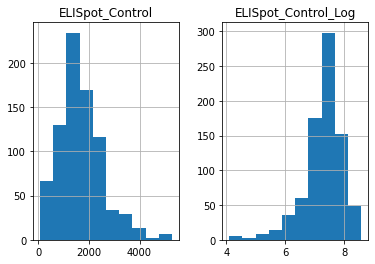

In [5]:
### ELISpot_Control is the ELISpot test result for the POSITIVE CONTROL (i.e., we expect to see strong response)
from numpy import log
data['ELISpot_Control_Log'] = log(data[['ELISpot_Control']])
data.hist(['ELISpot_Control', 'ELISpot_Control_Log'])
data.drop(['ELISpot_Control'], axis=1, inplace=True)

In [6]:
### Fills ELISpot_Result null rows with 0 ###
data.ELISpot_Result.fillna(0, inplace=True)
### Remove Outlier Rows for `ELISpot_Result` ###
data = data[(data.ELISpot_Result < data.ELISpot_Result.quantile(.97))]

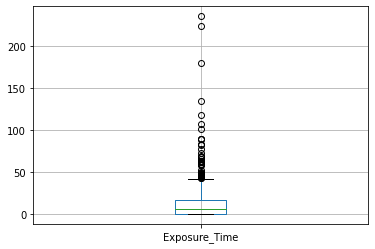

In [7]:
### Fills Exposure Time null rows with 0 ###
data.Exposure_Time.fillna(0, inplace=True)
### Remove Outlier Rows for `Exposure_Time` ###
data = data[(data.Exposure_Time < data.Exposure_Time.quantile(.987)) & (data.Exposure_Time >= 0)]
data.boxplot('Exposure_Time')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1028e9710>]],
      dtype=object)

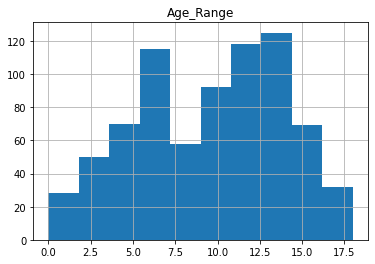

In [8]:
### Remove invalid rows from with 0 Age_Year
data = data[(data['Age_Year'] > 0)]
### Bin Age Year to Age Range ###
from pandas import cut
age_range = 5
num_bins = int(data.Age_Year.max() / age_range)
data['Age_Range'] = cut(data['Age_Year'], num_bins, labels=False)
data.drop(['Age_Year'], axis=1, inplace=True)
data.hist(['Age_Range'])

In [9]:
# Suspicion_Score is the suspicion level of the drug
# 1 = suspected drug
# 2 = similar to suspected drug
# 3 = negative control).
# This is ORDINAL.

suspicion = get_dummies(data['Suspicion_Score'], prefix='Suspicion_Score')
suspicion.rename(columns={
    'Suspicion_Score_1': 'Suspicion_Level_Suspected',
    'Suspicion_Score_2': 'Suspicion_Level_Near_Suspected',
    'Suspicion_Score_3': 'Suspicion_Level_Negative_Control'
}, inplace=True)
### To Merge or not to merge between Suspected and Near_Suspected
suspicion['Suspicion_Level_Suspected'] = suspicion['Suspicion_Level_Suspected'] + suspicion['Suspicion_Level_Near_Suspected']
suspicion.drop(['Suspicion_Level_Near_Suspected'], axis=1, inplace=True)
###
data = data.join(suspicion)
del suspicion
data.drop(['Suspicion_Score'], axis=1, inplace=True)

In [10]:
### Logs Final Shape and Columns before Regression ###
await logger.info(f'Test Data: {data.shape}')
await logger.info(f'Test Data Columns: {data.columns}')
await logger.info(f'Percentage of Null Data:\n{data.isnull().sum() / data.shape[0]}')

[INFO] Test Data: (757, 37)
[INFO] Test Data Columns: Index(['Patient_ID', 'Gender', 'ELISpot_Result', 'Exposure_Time',
       'Steroid_Usage', 'Underlying_Condition_A', 'Underlying_Condition_B',
       'Underlying_Condition_C', 'Underlying_Condition_D',
       'Underlying_Condition_E', 'Drug_Rechallenge_Result',
       'Allergic_Reaction_Group_1.0', 'Allergic_Reaction_Group_2.0',
       'Allergic_Reaction_Group_3.0', 'Allergic_Reaction_Group_4.0',
       'Allergic_Reaction_Group_5.0', 'Allergic_Reaction_Group_6.0',
       'Allergic_Reaction_Group_7.0', 'Allergic_Reaction_Group_8.0',
       'Allergic_Reaction_Group_nan', 'Drug_Group_1.0', 'Drug_Group_2.0',
       'Drug_Group_3.0', 'Drug_Group_4.0', 'Drug_Group_5.0', 'Drug_Group_6.0',
       'Drug_Group_7.0', 'Drug_Group_8.0', 'Drug_Group_nan',
       'Naranjo_Category_0.0', 'Naranjo_Category_1.0', 'Naranjo_Category_2.0',
       'Naranjo_Category_3.0', 'ELISpot_Control_Log', 'Age_Range',
       'Suspicion_Level_Suspected', 'Suspicion_Le

In [11]:
### Train Model ###
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

model = XGBClassifier()

trainable_data = data[data.Drug_Rechallenge_Result.notna()]
x_train = trainable_data.drop(['Patient_ID', 'Drug_Rechallenge_Result'], axis=1)
y_train = trainable_data['Drug_Rechallenge_Result']
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, train_size=.8, stratify=y_train)
model.fit(x_train, y_train)
await logger.info(model)

[INFO] RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [12]:
from math import sqrt
from sklearn.metrics import r2_score, mean_squared_error
y_predict = model.predict(x_test)
num_wrong_predictions = (y_predict != y_test).sum()
r2 = r2_score(y_test, y_predict)
mse = mean_squared_error(y_test, y_predict)
rmse = sqrt(mse)
await logger.info(f'Number of Wrong Predictions: {num_wrong_predictions} / {len(y_predict)}')
await logger.info(f'R2: {r2:.4f}')
await logger.info(f'Mean Squared Error: {mse:.4f}')
await logger.info(f'Root Mean Squared Error: {rmse:.4f}')

[INFO] Number of Wrong Predictions: 5 / 22
[INFO] R2: -0.2941
[INFO] Mean Squared Error: 0.2273
[INFO] Root Mean Squared Error: 0.4767
